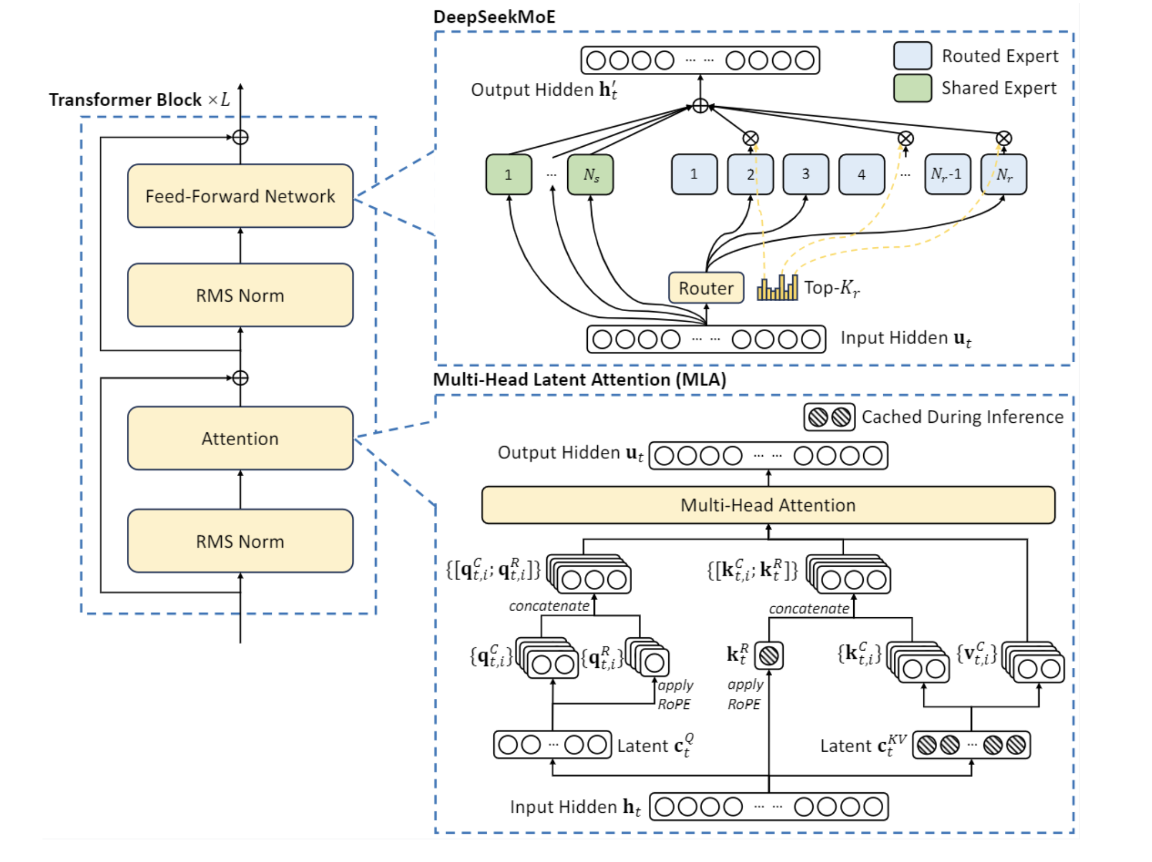

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional, Tuple
import math
from dataclasses import dataclass

In [2]:
# 一些前置函数，主要是两个函数，一个 RMSNorm 的实现以及 ROPE 函数的实现
class DeepseekV2RMSNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.variance_epsilon = eps

    def forward(self, hidden_states):
        input_dtype = hidden_states.dtype
        hidden_states = hidden_states.to(torch.float32)
        variance = hidden_states.pow(2).mean(-1, keepdim=True)
        hidden_states = hidden_states * torch.rsqrt(variance + self.variance_epsilon)
        return self.weight * hidden_states.to(input_dtype)
    
class DeepseekV2RotaryEmbedding(nn.Module):
    def __init__(self, dim, max_position_embeddings=2048, base=10000, device=None):
        super().__init__()

        self.dim = dim
        self.max_position_embeddings = max_position_embeddings
        self.base = base
        inv_freq = 1.0 / (
            self.base ** (torch.arange(0, self.dim, 2).float().to(device) / self.dim)
        )
        self.register_buffer("inv_freq", inv_freq, persistent=False)
        # 较小索引位置对应较低频率
        # 较大的索引位置有较高的频率
        
        # Build here to make `torch.jit.trace` work.
        self._set_cos_sin_cache(
            seq_len=max_position_embeddings,
            device=self.inv_freq.device,
            dtype=torch.get_default_dtype(),
        )
        self.max_seq_len_cached = None

    def _set_cos_sin_cache(self, seq_len, device, dtype):
        self.max_seq_len_cached = seq_len
        t = torch.arange(
            self.max_seq_len_cached, device=device, dtype=self.inv_freq.dtype
        )

        freqs = torch.outer(t, self.inv_freq.to(t.device))
        # Different from paper, but it uses a different permutation in order to obtain the same calculation
        emb = torch.cat((freqs, freqs), dim=-1)
        self.register_buffer("cos_cached", emb.cos().to(dtype), persistent=False)
        self.register_buffer("sin_cached", emb.sin().to(dtype), persistent=False)

    def forward(self, x, seq_len=None):
        # x: [bs, num_attention_heads, seq_len, head_size]
        if self.max_seq_len_cached is None or seq_len > self.max_seq_len_cached:
            self._set_cos_sin_cache(seq_len=seq_len, device=x.device, dtype=x.dtype)

        return (
            self.cos_cached[:seq_len].to(dtype=x.dtype),
            self.sin_cached[:seq_len].to(dtype=x.dtype),
        )

# Copied from transformers.models.llama.modeling_llama.rotate_half
def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)

# Copied from transformers.models.llama.modeling_llama.apply_rotary_pos_emb
def apply_rotary_pos_emb(q, k, cos, sin, position_ids, unsqueeze_dim=1):
    cos = cos[position_ids].unsqueeze(unsqueeze_dim)
    sin = sin[position_ids].unsqueeze(unsqueeze_dim)

    b, h, s, d = q.shape
    q = q.view(b, h, s, d // 2, 2).transpose(4, 3).reshape(b, h, s, d)

    b, h, s, d = k.shape
    k = k.view(b, h, s, d // 2, 2).transpose(4, 3).reshape(b, h, s, d)

    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

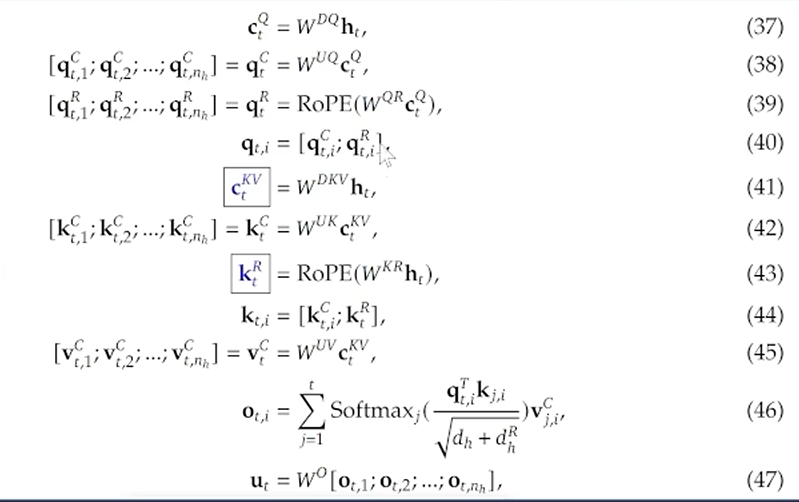

In [13]:
@dataclass
class DeepseekConfig:
    hidden_size: int
    num_heads: int
    max_position_embeddings: int
    rope_theta: float
    attention_dropout: float

    q_lora_rank: int # latent的shape 一般设置1536
    qk_rope_head_dim: int  # 64
    kv_lora_rank: int  # 公式41  可能是512
    v_head_dim: int  # 128
    qk_nope_head_dim: int
    attention_bias: bool  # 现在的大模型一般是false


class MLA(nn.Module):
    def __init__(self, config: DeepseekConfig):
        # 三个部分
        # part1 mha部分
        super().__init__()
        self.attention_dropout = config.attention_dropout
        self.hidden_size = config.hidden_size
        self.num_heads = config.num_heads
        self.v_head_dim = config.v_head_dim
        self.q_head_dim = config.qk_nope_head_dim+config.qk_rope_head_dim
        self.qk_nope_head_dim = config.qk_nope_head_dim
        self.qk_rope_head_dim = config.qk_rope_head_dim

        self.out_proj = nn.Linear(
            self.num_heads * self.v_head_dim,
            self.hidden_size,
            bias = False
        )

        # part2 MLA压缩部分
        # p2.1 down压缩
        # 一般会从7168->1536 压缩1/4.7
        # q上采样以后再拆分，k下采样以后就已经拆分了
        # k在压缩阶段即完成拆分，使每个头的Key维度极低（如16），KV缓存减少93.3%
        # q通过上采样保留原始语义信息再拆分，避免压缩导致注意力权重计算偏差
        self.q_lora_rank = config.q_lora_rank
        self.kv_lora_rank = config.kv_lora_rank
        self.q_down_proj = nn.Linear(
            self.hidden_size,
            self.q_lora_rank,
            bias = config.attention_bias
        )
        self.q_down_norm = DeepseekV2RMSNorm(self.q_lora_rank)
        self.kv_down_proj = nn.Linear(
            self.hidden_size,
            self.kv_lora_rank + config.qk_rope_head_dim,
            bias = config.attention_bias
        )
        self.kv_down_norm = DeepseekV2RMSNorm(self.kv_lora_rank)

        self.q_head_dim = config.qk_nope_head_dim+config.qk_rope_head_dim
        self.q_up_proj = nn.Linear(
            self.q_lora_rank,
            self.num_heads*self.q_head_dim,
            bias = config.attention_bias
        ) 

        self.kv_up_proj = nn.Linear(
            self.kv_lora_rank,
            self.num_heads * (
                self.q_head_dim - config.qk_rope_head_dim + self.v_head_dim
            ),# self.q_head_dim - config.qk_rope_head_dim = nope_shape
            bias = config.attention_bias
        )

        # part3 rope部分
        self.rotary_emb = DeepseekV2RotaryEmbedding(
            config.qk_rope_head_dim,# qk的ropedim是一样 不是qk的ropedim相加的意思
            config.max_position_embeddings,
            config.rope_theta
        )
    def forward(self, hidden_states, position_ids, attention_mask = None):
        bsz, q_len, _ = hidden_states.size()
        q = self.q_down_proj(
            hidden_states
        )
        q = self.q_down_norm(q)
        q = self.q_up_proj(q)
        # q shape   num_head*q_head_dim
        # (b seq_len num_head*q_head_dim)
        q = q.view(bsz, q_len, self.num_heads, self.q_head_dim).transpose(1,2)
        q_nope, q_rope = torch.split(
            q,
            [self.qk_nope_head_dim, self.qk_rope_head_dim],
            dim=-1
            
        )
        
        c_kv = self.kv_down_proj(hidden_states)
        c_kv, k_rope = torch.split(
            c_kv,
            [self.kv_lora_rank, self.qk_rope_head_dim],
            dim=-1
        )
        # k_rope的shape b seq_len self.qk_rope_head_dim
        # 只有一个头
        k_rope = k_rope.reshape(
            bsz,q_len,1,self.qk_rope_head_dim
        ).transpose(1,2)
        #(b 1 q_len, self.qk_rope_head_dim)
        kv = self.kv_down_norm(c_kv)
        kv = self.kv_up_proj(kv)
        kv = kv.view(bsz,q_len,self.num_heads,self.qk_nope_head_dim+self.v_head_dim).transpose(1,2)
        k_nope, value_states = torch.split(
            kv,
            [self.qk_nope_head_dim,self.v_head_dim],
            dim=-1
        )
        # value_states(b numhead seqlen v_headdim)
        kv_seq_len = value_states.shape[-2]
        cos,sin = self.rotary_emb(
            value_states,seq_len = kv_seq_len,
        )
        q_rope, k_rope = apply_rotary_pos_emb(
            q_rope,k_rope,cos,sin,position_ids
        )

        query_states = torch.concat(
            [q_nope, q_rope],dim=-1
        )
        # 注意要concat倒数第一维度  前面的shape需要一模一样 不能广播
        key_states = torch.concat(
            [k_nope,k_rope.expand(-1,self.num_heads,-1,-1)],
            dim=-1
        )
        # shape b num_head qlen  headdim=(qk_nope+qk_rope)

        attn_weights = torch.matmul(query_states, key_states.transpose(2, 3))
        attn_weights = attn_weights / math.sqrt(self.q_head_dim)

        if attention_mask is not None:
            attn_weights = torch.masked_fill(
                attn_weights,
                attention_mask == 0,
                float("-inf"),
            )

        # 6. Softmax and dropout
        attn_weights = F.softmax(
            attn_weights, dim=-1, dtype=torch.float32).to(query_states.dtype)
        attn_weights = F.dropout(
            attn_weights, p=self.attention_dropout, training=self.training)

        # 7. Compute attention output
        attn_output = torch.matmul(attn_weights, value_states)
        attn_output = attn_output.transpose(1, 2).reshape(bsz, q_len, -1)
        # attn_output = self.o_proj(attn_output)

        return attn_output, attn_weights
        
        

In [14]:
# 写一个测试函数
def test_mla():
    config = DeepseekConfig(
        hidden_size=7168,
        num_heads=16,
        max_position_embeddings=1024,
        rope_theta=128000,
        attention_dropout=0.1,
        q_lora_rank=1536,
        qk_rope_head_dim=64,
        kv_lora_rank=512,
        
        v_head_dim=128,
        qk_nope_head_dim=128,
        attention_bias=False,
    )

    mla = MLA(config)
    x = torch.randn(2, 1024, 7168)
    position_ids = torch.arange(
        config.max_position_embeddings,
    ).unsqueeze(0).expand(
        x.size(0), -1
    )
    attn_output, attn_weights = mla(x, position_ids=position_ids)
    print(attn_output.shape)
    print(attn_weights.shape)


test_mla()

torch.Size([2, 1024, 2048])
torch.Size([2, 16, 1024, 1024])
